In [1]:
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random.mtrand import random_sample
from sklearn.preprocessing import *
from scipy import stats

from data_cleaning import numerical_vars

In [35]:
df = pd.read_csv('./csv/transformed.csv')
df = df.drop(columns=['Unnamed: 0'])
df.columns

Index(['BMI_q_normal', 'MentHlth', 'PhysHlth_q_uniform', 'GenHlth_q_uniform',
       'Age_q_uniform', 'Education_coxbox', 'Income_q_uniform', 'Diabetes_012',
       'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex'],
      dtype='object')

In [36]:
# Categorical Variables
nominal_vars = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker',
    'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits',
    'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost',
    'DiffWalk', 'Sex'
]

ordinal_vars = [
    'Education_coxbox', 'Income_q_uniform'
]

# quantitative Variables
quantitative_vars = [
    'BMI_q_normal', 'MentHlth', 'PhysHlth_q_uniform', 'GenHlth_q_uniform', 'Age_q_uniform'
]

categorical_vars = ordinal_vars + nominal_vars

response_var = 'Diabetes_012'

df_nominal = df[nominal_vars]
df_ordinal = df[ordinal_vars]
df_quantitative = df[quantitative_vars]
df_categorical = df[categorical_vars]

In [37]:
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [38]:
def stratified_sample_df(df, col, n_samples):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n,random_state=0))
    df_.index = df_.index.droplevel(0)
    return df_

# Class balance

In [39]:
outliers_info = pd.DataFrame(columns=['Variable', 'Percentage of 0s', 'Percentage of 1s', 'Percentage of 2s'])


counts = df[response_var].value_counts(normalize=True) * 100
pct_zeros = counts.get(0, 0)
pct_ones = counts.get(1, 0)
pct_twos = counts.get(2, 0)

outliers_info.loc[-1] = [response_var, pct_zeros, pct_ones, pct_twos]
outliers_info.index = outliers_info.index + 1
outliers_info = outliers_info.sort_index()

# Display the outlier information DataFrame
outliers_info

,Variable,Percentage of 0s,Percentage of 1s,Percentage of 2s
0,Diabetes_012,84.24117,1.825528,13.933302


In order to find outliers using models, we will first stratify the dataset for reliable outlier detection.

In [46]:
stratified_df = stratified_sample_df(df, response_var, 0.1825 * df.shape[0])

# Outlier detection in numerical and ordered variables

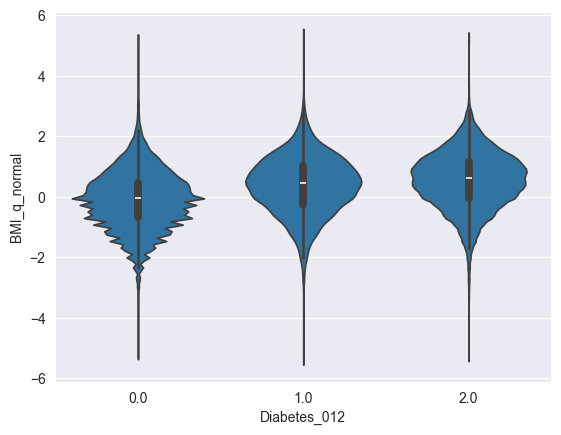

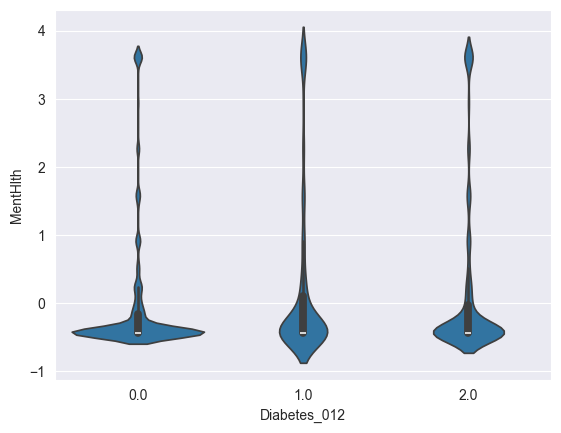

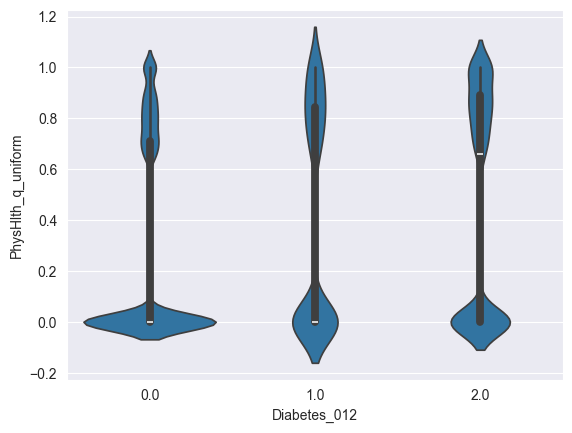

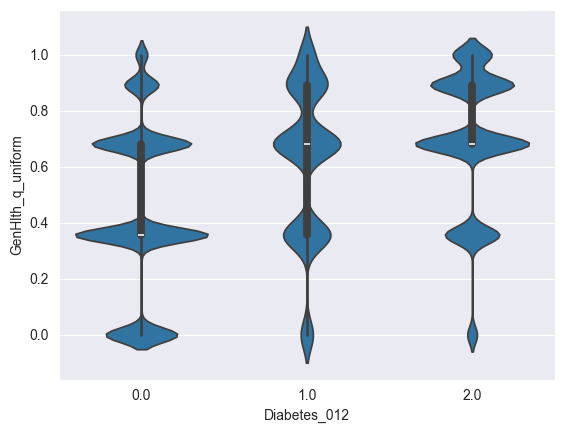

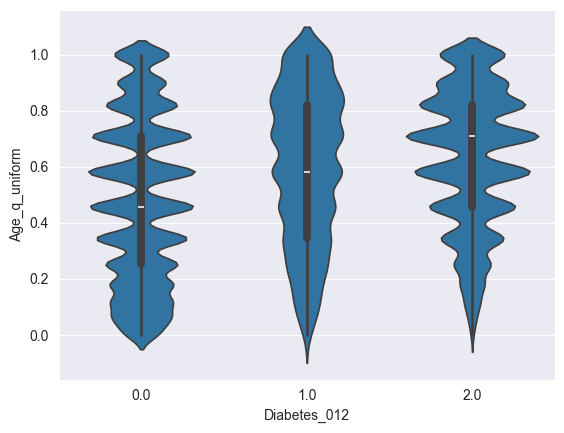

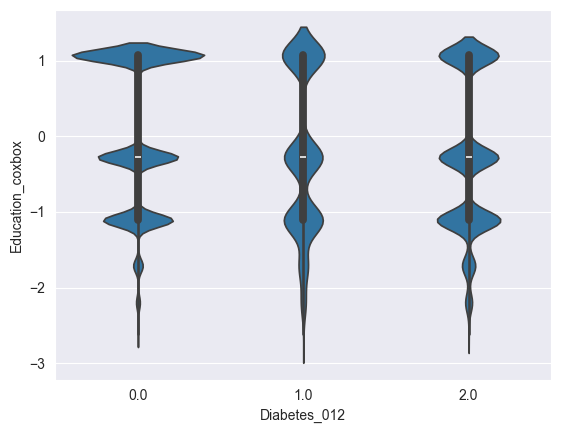

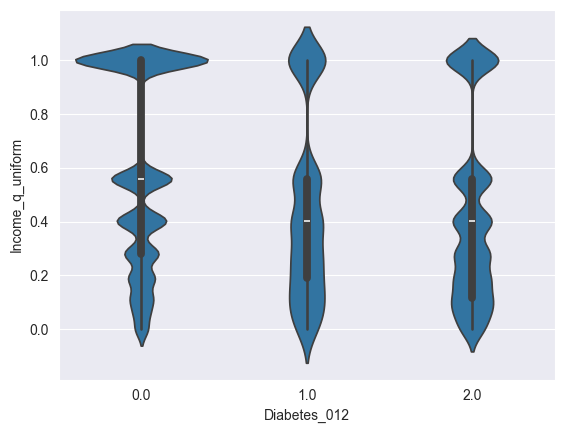

In [90]:
for var in quantitative_vars + ordinal_vars:
    sns.violinplot(data=df, x=response_var, y=var)
    plt.show()

# Outlier detection with models

In [47]:
outliers_info = pd.DataFrame(columns=['Variable', 'Percentage of 0s', 'Percentage of 1s', 'Imbalanced'])

for var in nominal_vars:
    counts = stratified_df[var].value_counts(normalize=True) * 100
    pct_zeros = counts.get(0, 0)
    pct_ones = counts.get(1, 0)
    # Mark as imbalanced if either 0 or 1 has less than 10% or more than 90%
    imbalanced = pct_zeros < 10 or pct_zeros > 90 or pct_ones < 10 or pct_ones > 90
    
    outliers_info.loc[-1] = [var, pct_zeros, pct_ones, imbalanced]
    outliers_info.index = outliers_info.index + 1
    outliers_info = outliers_info.sort_index()

# Display the outlier information DataFrame
outliers_info.sort_values(by='Imbalanced', ascending=False)

,Variable,Percentage of 0s,Percentage of 1s,Imbalanced
3,AnyHealthcare,4.944936,95.055064,True
4,HvyAlcoholConsump,95.458144,4.541856,True
9,Stroke,93.543511,6.456489,True
11,CholCheck,2.044195,97.955805,True
0,Sex,55.258044,44.741956,False
1,DiffWalk,73.648600,26.351400,False
2,NoDocbcCost,89.224789,10.775211,False
5,Veggies,21.831138,78.168862,False
6,Fruits,39.120420,60.879580,False
7,PhysActivity,30.173469,69.826531,False


In [78]:
lof_outlier = LocalOutlierFactor(novelty=True).fit(stratified_df)

In [79]:
outlierSVM = OneClassSVM(gamma='auto', nu=0.01).fit(stratified_df)

In [80]:
outlierIF = IsolationForest(random_state=0,contamination=0.01).fit(stratified_df)

In [81]:
df_w_outlier = df.copy()
df_w_outlier['outlier_isof'] = outlierIF.predict(df)
df_w_outlier['outlier_svm'] = outlierSVM.predict(df)
df_w_outlier['outlier_lof'] = lof_outlier.predict(df)

C:\Users\franb\PycharmProjects\MLPracticals\venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [82]:
outliers_info = pd.DataFrame(columns=['Variable', 'Percentage of -1s', 'Percentage of 1s'])

for var in ['outlier_isof', 'outlier_lof', 'outlier_svm']:
    counts = df_w_outlier[var].value_counts(normalize=True) * 100
    pct_zeros = counts.get(-1, 0)
    pct_ones = counts.get(1, 0)
    
    outliers_info.loc[-1] = [var, pct_zeros, pct_ones]
    outliers_info.index = outliers_info.index + 1
    outliers_info = outliers_info.sort_index()

# Display the outlier information DataFrame
outliers_info.sort_values(by='Percentage of -1s', ascending=False)

,Variable,Percentage of -1s,Percentage of 1s
1,outlier_lof,1.987149,98.012851
0,outlier_svm,1.197572,98.802428
2,outlier_isof,0.855408,99.144592


In [83]:
df_w_outlier['outlier_oneOfThree'] = np.where((df_w_outlier[['outlier_isof', 'outlier_lof', 'outlier_svm']] == 1).sum(axis=1) < 3, -1, 1)
df_w_outlier['outlier_twoOfThree'] = np.where((df_w_outlier[['outlier_isof', 'outlier_lof', 'outlier_svm']] == 1).sum(axis=1) < 1, -1, 1)
df_w_outlier['outlier_threeOfThree'] = np.where((df_w_outlier[['outlier_isof', 'outlier_lof', 'outlier_svm']] == 1).sum(axis=1) < -1, -1, 1)

In [84]:
outliers_info = pd.DataFrame(columns=['Variable', 'Percentage of -1s', 'Percentage of 1s'])

for var in ['outlier_isof', 'outlier_lof', 'outlier_svm', 'outlier_oneOfThree', 'outlier_twoOfThree', 'outlier_threeOfThree']:
    counts = df_w_outlier[var].value_counts(normalize=True) * 100
    pct_zeros = counts.get(-1, 0)
    pct_ones = counts.get(1, 0)
    
    outliers_info.loc[-1] = [var, pct_zeros, pct_ones]
    outliers_info.index = outliers_info.index + 1
    outliers_info = outliers_info.sort_index()

# Display the outlier information DataFrame
outliers_info.sort_values(by='Percentage of -1s', ascending=False)

,Variable,Percentage of -1s,Percentage of 1s
2,outlier_oneOfThree,3.696389,96.303611
4,outlier_lof,1.987149,98.012851
3,outlier_svm,1.197572,98.802428
5,outlier_isof,0.855408,99.144592
1,outlier_twoOfThree,0.013403,99.986597
0,outlier_threeOfThree,0.000000,100.000000


In [102]:
outliers_info = pd.DataFrame(columns=['Variable', 'Percentage of 0s', 'Percentage of 1s', 'Percentage of 2s'])


counts = df[response_var].value_counts(normalize=True) * 100
pct_zeros = counts.get(0, 0)
pct_ones = counts.get(1, 0)
pct_twos = counts.get(2, 0)

outliers_info.loc[-1] = ['Original', pct_zeros, pct_ones, pct_twos]
outliers_info.index = outliers_info.index + 1
outliers_info = outliers_info.sort_index()

for var in ['outlier_oneOfThree',
    'outlier_lof',
    'outlier_svm',
    'outlier_isof',
    'outlier_twoOfThree'
    ]:
    counts = df[df_w_outlier[var]==1][response_var].value_counts(normalize=True) * 100
    pct_zeros = counts.get(0, 0)
    pct_ones = counts.get(1, 0)
    pct_twos = counts.get(2, 0)
    
    outliers_info.loc[-1] = [var, pct_zeros, pct_ones, pct_twos]
    outliers_info.index = outliers_info.index + 1
    outliers_info = outliers_info.sort_index()

# Display the outlier information DataFrame
outliers_info.sort_values(by='Percentage of 0s', ascending=False)

,Variable,Percentage of 0s,Percentage of 1s,Percentage of 2s
1,outlier_isof,84.256292,1.823387,13.920321
5,Original,84.241170,1.825528,13.933302
0,outlier_twoOfThree,84.240635,1.825773,13.933592
2,outlier_svm,84.238875,1.839277,13.921849
4,outlier_oneOfThree,83.954761,1.867353,14.177886
3,outlier_lof,83.934540,1.859724,14.205736


The method for outlier detection that preserves the class balance happens to be the voting system using majority voting (2 must agree on outlier status).
Let us plot this method to see if we can see any difference.

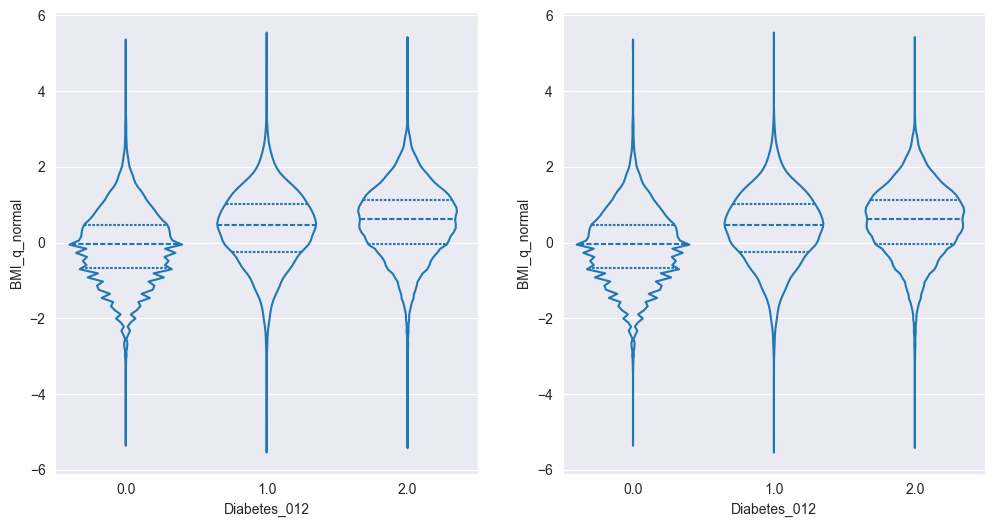

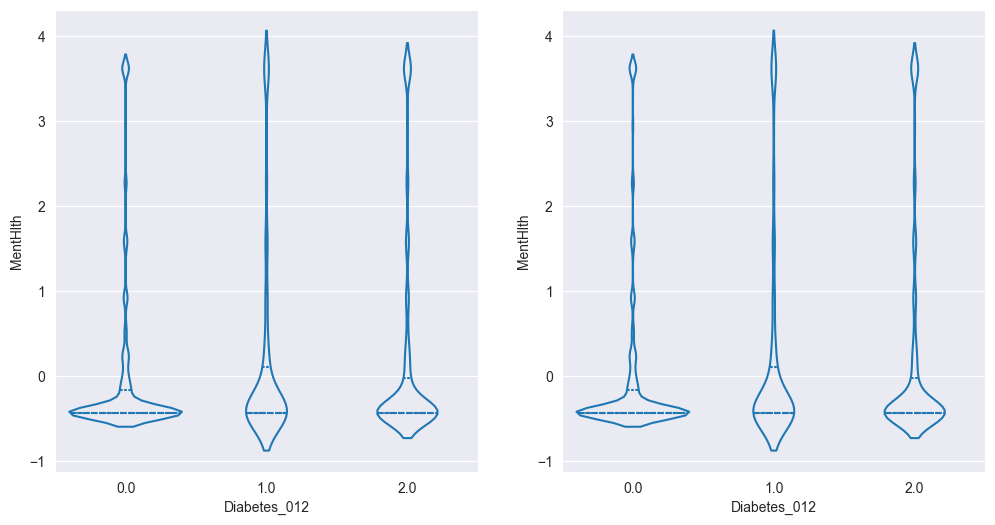

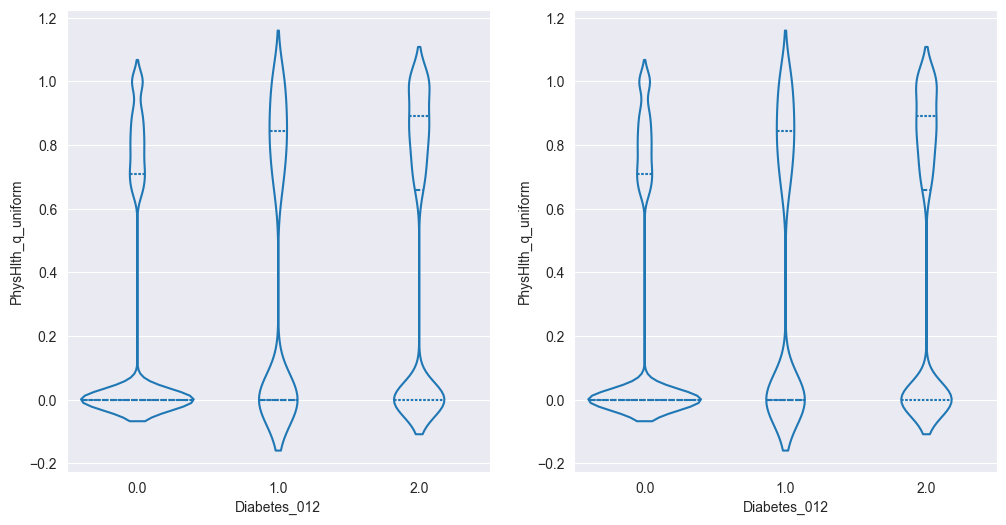

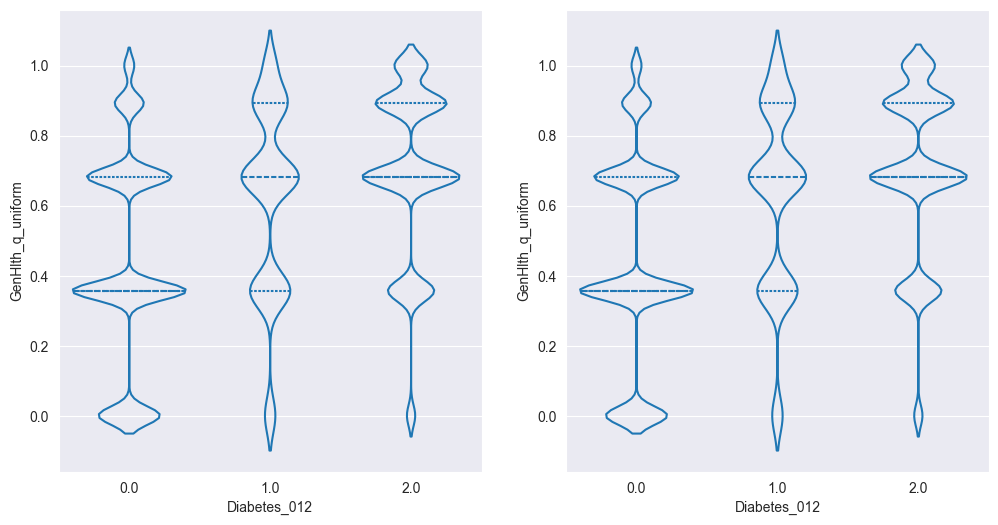

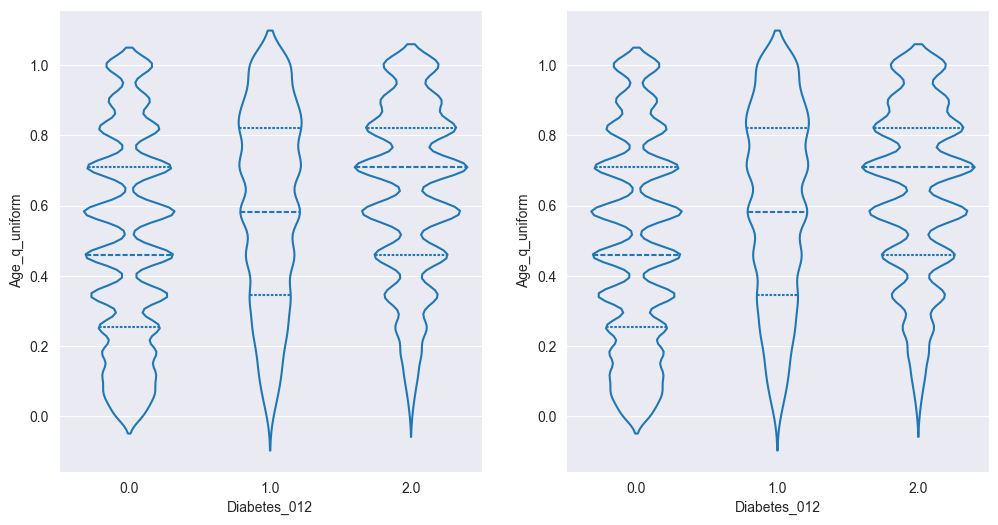

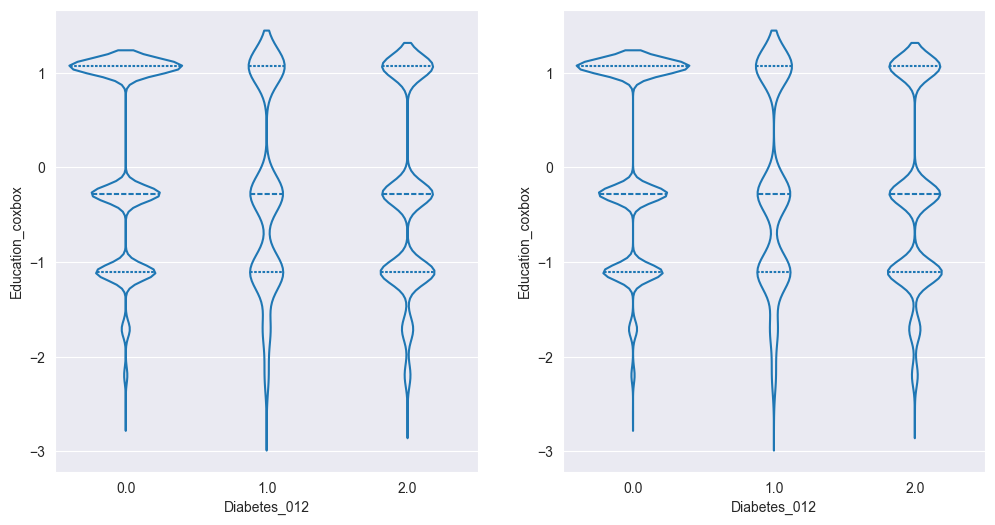

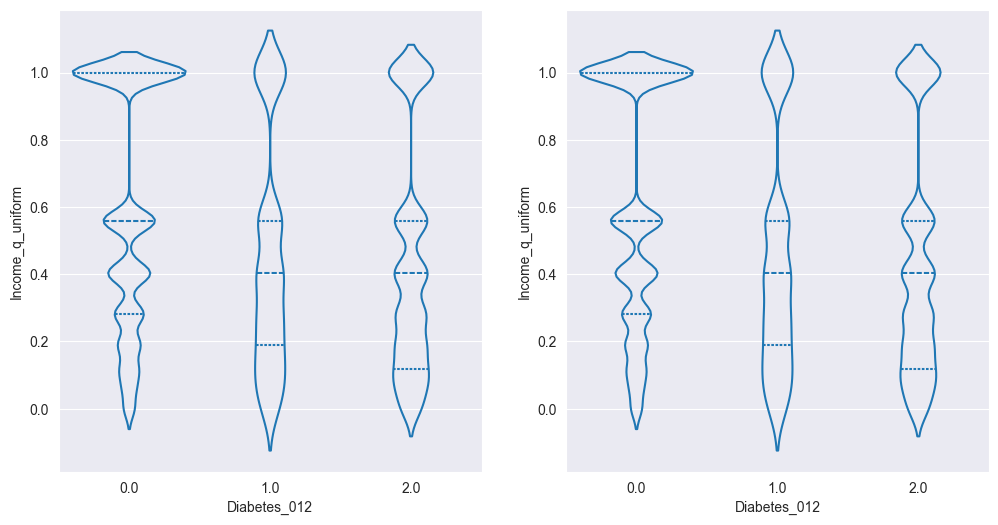

In [103]:
df_without_outliers = df[df_w_outlier['outlier_twoOfThree'] == 1] 
for var in quantitative_vars + ordinal_vars:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    sns.violinplot(data=df, x=response_var, y=var, fill=False, inner="quart")
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, first subplot
    sns.violinplot(data=df_without_outliers, x=response_var, y=var, fill=False, inner="quart")
    plt.show()

In [107]:
outliers_info = pd.DataFrame(columns=['Variable', 'Percentage of 0s Originally', 'Percentage of 0s Now', 'Difference'])

for var in nominal_vars:
    counts = df[var].value_counts(normalize=True) * 100
    pct_zeros1 = counts.get(0, 0)
    counts = df_without_outliers[var].value_counts(normalize=True) * 100
    pct_zeros2 = counts.get(0, 0)
    # Mark as imbalanced if either 0 or 1 has less than 10% or more than 90%
    
    outliers_info.loc[-1] = [var, pct_zeros1, pct_zeros2, pct_zeros1 - pct_zeros2]
    outliers_info.index = outliers_info.index + 1
    outliers_info = outliers_info.sort_index()

# Display the outlier information DataFrame
outliers_info.sort_values(by='Variable', ascending=False)

,Variable,Percentage of 0s Originally,Percentage of 0s Now,Difference
5,Veggies,18.858010,18.856201,0.001809
9,Stroke,95.942920,95.945136,-0.002216
10,Smoker,55.683144,55.685089,-0.001945
0,Sex,55.965784,55.964612,0.001172
7,PhysActivity,24.345632,24.342982,0.002650
2,NoDocbcCost,91.582308,91.591431,-0.009122
4,HvyAlcoholConsump,94.380322,94.383117,-0.002795
12,HighChol,57.587906,57.586558,0.001348
13,HighBP,57.099890,57.096899,0.002991
8,HeartDiseaseorAttack,90.581441,90.584515,-0.003074


The differences in distributions seem to be minimal. Slightly higher on NoDocbcCost than the others.

In [109]:
df_without_outliers.to_csv('./csv/outlier_filtered.csv', index=False)